# SpendSense – Exploratory Data Analysis (EDA)

This notebook explores the synthetic financial dataset to understand:

- Overall fraud rate (`is_fraudulent` distribution)
- Fraud by:
  - `purchase_category`
  - `card_type`
  - `location`
  - Transaction time (hour of day, and day of week if possible)
  - `customer_age`
- Amount distribution in fraudulent vs non-fraudulent transactions
- Save figures to `reports/figures/` for later use in docs and README.


In [33]:
import os
from pathlib import Path

import duckdb
import pandas as pd
import matplotlib.pyplot as plt


In [34]:
PROJECT_ROOT = Path("..").resolve()

DATA_PATH = PROJECT_ROOT / "data" / "raw" / "synthetic_financial_data.csv"
DB_PATH = PROJECT_ROOT / "spendsense.duckdb"   # store DB in project root
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"

FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PATH:", DATA_PATH)
print("DB_PATH:", DB_PATH)
print("FIGURES_DIR:", FIGURES_DIR)

# Connect to DuckDB
con = duckdb.connect(str(DB_PATH))

# Load data from CSV via DuckDB (simpler, no f-string issue)
query = """
    SELECT *
    FROM read_csv_auto(?, header=True)
"""
df = con.execute(query, [DATA_PATH.as_posix()]).df()

# Clean up column names
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

df.head()

PROJECT_ROOT: C:\Users\akash\Spendsense-financial-intelligence
DATA_PATH: C:\Users\akash\Spendsense-financial-intelligence\data\raw\synthetic_financial_data.csv
DB_PATH: C:\Users\akash\Spendsense-financial-intelligence\spendsense.duckdb
FIGURES_DIR: C:\Users\akash\Spendsense-financial-intelligence\reports\figures


,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083


In [35]:
# Number of rows and columns
print("Shape (rows, columns):", df.shape)

# Quick info on dtypes and missing values
print("\nDataFrame info:")
df.info()

# Basic numeric summary
print("\nNumeric summary:")
display(df.describe())

# Preview the unique values of key categorical columns
categorical_cols = ["purchase_category", "card_type", "location"]
for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(df[col].unique()[:20])  # show up to 20 unique values


Shape (rows, columns): (10000, 11)

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           10000 non-null  int64         
 1   customer_id              10000 non-null  int64         
 2   merchant_id              10000 non-null  int64         
 3   amount                   10000 non-null  float64       
 4   transaction_time         10000 non-null  datetime64[us]
 5   is_fraudulent            10000 non-null  int64         
 6   card_type                10000 non-null  object        
 7   location                 10000 non-null  object        
 8   purchase_category        10000 non-null  object        
 9   customer_age             10000 non-null  int64         
 10  transaction_description  10000 non-null  object        
dtypes: datetime64[us](1), float64(1), int64(5)

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,customer_age
count,10000.00000,10000.000000,10000.000000,10000.000000,10000,10000.000000,10000.000000
mean,5000.50000,1051.272300,2050.486600,4958.381617,2023-01-01 01:23:19.500000,0.506800,44.047500
min,1.00000,1001.000000,2001.000000,10.610000,2023-01-01 00:00:00,0.000000,18.000000
25%,2500.75000,1026.000000,2025.000000,2438.175000,2023-01-01 00:41:39.750000,0.000000,31.000000
50%,5000.50000,1052.000000,2050.000000,4943.945000,2023-01-01 01:23:19.500000,1.000000,44.000000
75%,7500.25000,1076.000000,2076.000000,7499.312500,2023-01-01 02:04:59.250000,1.000000,57.000000
max,10000.00000,1100.000000,2100.000000,9999.750000,2023-01-01 02:46:39,1.000000,70.000000
std,2886.89568,28.864062,28.877801,2899.699675,NaN,0.499979,15.321707



Unique values in purchase_category:
['Gas Station' 'Online Shopping' 'Travel' 'Retail' 'Groceries'
 'Restaurant']

Unique values in card_type:
['MasterCard' 'Visa' 'Discover' 'American Express']

Unique values in location:
['City-30' 'City-47' 'City-6' 'City-34' 'City-1' 'City-7' 'City-46'
 'City-45' 'City-25' 'City-29' 'City-19' 'City-13' 'City-4' 'City-17'
 'City-35' 'City-40' 'City-38' 'City-22' 'City-39' 'City-10']


In [36]:
# 1. time conversion + derived fields
df["transaction_time"] = pd.to_datetime(df["transaction_time"], errors="coerce")
df["transaction_hour"] = df["transaction_time"].dt.hour
df["transaction_dayofweek"] = df["transaction_time"].dt.dayofweek

# 2. DEBUGGING CELL for time features
print("Raw transaction_time sample:")
print(df["transaction_time"].head(25))

print("\nData type:", df["transaction_time"].dtype)

print("\nHour counts:")
print(df["transaction_hour"].value_counts(dropna=False).head())

print("\nDay of week counts:")
print(df["transaction_dayofweek"].value_counts(dropna=False).head())


Raw transaction_time sample:
0    2023-01-01 00:00:00
1    2023-01-01 00:00:01
2    2023-01-01 00:00:02
3    2023-01-01 00:00:03
4    2023-01-01 00:00:04
5    2023-01-01 00:00:05
6    2023-01-01 00:00:06
7    2023-01-01 00:00:07
8    2023-01-01 00:00:08
9    2023-01-01 00:00:09
10   2023-01-01 00:00:10
11   2023-01-01 00:00:11
12   2023-01-01 00:00:12
13   2023-01-01 00:00:13
14   2023-01-01 00:00:14
15   2023-01-01 00:00:15
16   2023-01-01 00:00:16
17   2023-01-01 00:00:17
18   2023-01-01 00:00:18
19   2023-01-01 00:00:19
20   2023-01-01 00:00:20
21   2023-01-01 00:00:21
22   2023-01-01 00:00:22
23   2023-01-01 00:00:23
24   2023-01-01 00:00:24
Name: transaction_time, dtype: datetime64[us]

Data type: datetime64[us]

Hour counts:
transaction_hour
0    3600
1    3600
2    2800
Name: count, dtype: int64

Day of week counts:
transaction_dayofweek
6    10000
Name: count, dtype: int64


Fraud counts:
is_fraudulent
1    5068
0    4932
Name: count, dtype: int64

Overall fraud rate: 50.680%


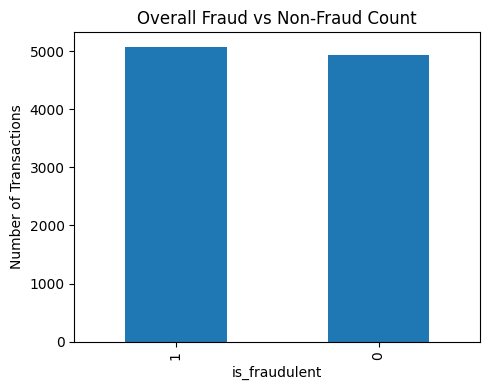

Saved figure to: C:\Users\akash\Spendsense-financial-intelligence\reports\figures\fraud_overall_bar.png


In [37]:
# Overall fraud distribution
fraud_counts = df["is_fraudulent"].value_counts(dropna=False)
fraud_rate = df["is_fraudulent"].mean()  # assuming 1 = fraud, 0 = non-fraud

print("Fraud counts:")
print(fraud_counts)
print(f"\nOverall fraud rate: {fraud_rate:.3%}")

# Plot overall fraud distribution
plt.figure(figsize=(5, 4))
fraud_counts.plot(kind="bar")
plt.title("Overall Fraud vs Non-Fraud Count")
plt.xlabel("is_fraudulent")
plt.ylabel("Number of Transactions")
plt.tight_layout()

fig_path = FIGURES_DIR / "fraud_overall_bar.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print("Saved figure to:", fig_path)


In [38]:
def plot_fraud_rate_by_column(df, column, figsize=(8, 4), filename_prefix="fraud_by"):
    """
    Compute and plot fraud rate by a categorical column.
    Saves the figure to reports/figures/.
    """
    # Drop rows with missing values in that column
    temp = df.dropna(subset=[column])

    # Group by the column and compute fraud rate and counts
    grouped = (
        temp
        .groupby(column)["is_fraudulent"]
        .agg(fraud_rate="mean", count="size")
        .sort_values("fraud_rate", ascending=False)
    )

    print(f"\nFraud rate by {column}:")
    display(grouped)

    # Plot fraud rate
    plt.figure(figsize=figsize)
    grouped["fraud_rate"].plot(kind="bar")
    plt.title(f"Fraud Rate by {column}")
    plt.ylabel("Fraud Rate")
    plt.xlabel(column)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    fig_path = FIGURES_DIR / f"{filename_prefix}_{column}.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()

    print("Saved figure to:", fig_path)



Fraud rate by purchase_category:


,fraud_rate,count
purchase_category,,
Groceries,0.529551,1692
Gas Station,0.524610,1666
Retail,0.513546,1661
Travel,0.505313,1694
Online Shopping,0.486978,1651
Restaurant,0.479829,1636


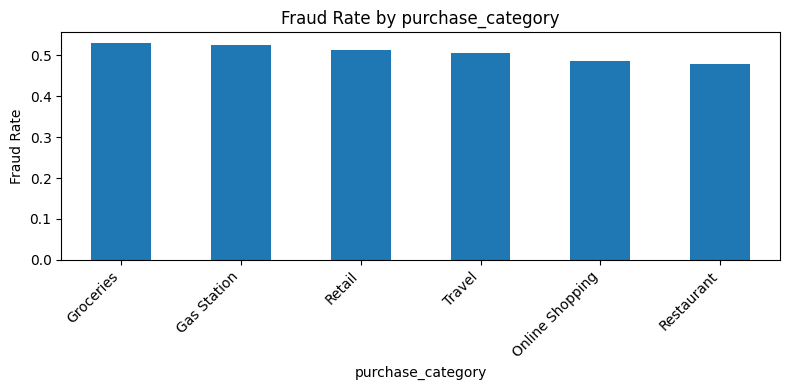

Saved figure to: C:\Users\akash\Spendsense-financial-intelligence\reports\figures\fraud_by_category_purchase_category.png

Fraud rate by card_type:


,fraud_rate,count
card_type,,
MasterCard,0.521611,2383
Visa,0.507631,2490
Discover,0.504747,2633
American Express,0.493986,2494


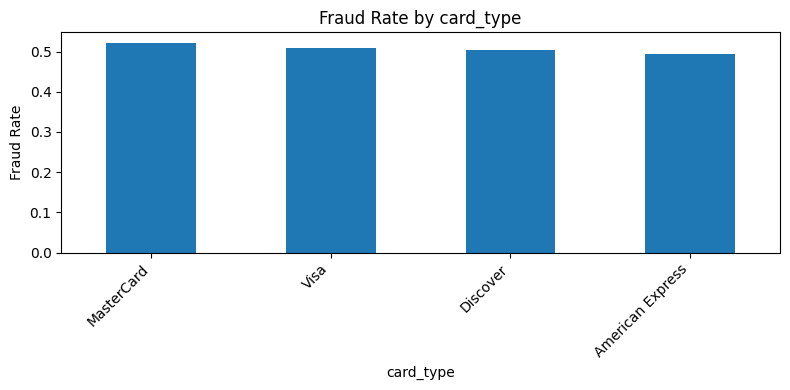

Saved figure to: C:\Users\akash\Spendsense-financial-intelligence\reports\figures\fraud_by_card_type_card_type.png

Fraud rate by location:


,fraud_rate,count
location,,
City-6,0.600000,190
City-31,0.576271,177
City-1,0.574468,188
City-48,0.569307,202
City-26,0.567708,192
City-44,0.566138,189
City-35,0.550633,158
City-23,0.545455,209
City-18,0.541237,194


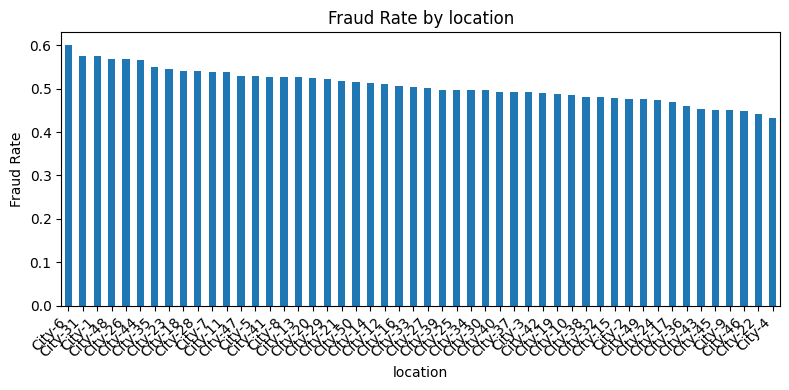

Saved figure to: C:\Users\akash\Spendsense-financial-intelligence\reports\figures\fraud_by_location_location.png


In [39]:
# Fraud rate by purchase_category
plot_fraud_rate_by_column(df, "purchase_category", filename_prefix="fraud_by_category")

# Fraud rate by card_type
plot_fraud_rate_by_column(df, "card_type", filename_prefix="fraud_by_card_type")

# Fraud rate by location
plot_fraud_rate_by_column(df, "location", filename_prefix="fraud_by_location")



Fraud rate by age_group:


C:\Users\akash\AppData\Local\Temp\ipykernel_1440\3371328707.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(column)["is_fraudulent"]


,fraud_rate,count
age_group,,
18-24,0.518574,1346
25-34,0.514738,1832
65+,0.509170,1145
55-64,0.504306,1858
45-54,0.502330,1931
35-44,0.496292,1888
<18,NaN,0


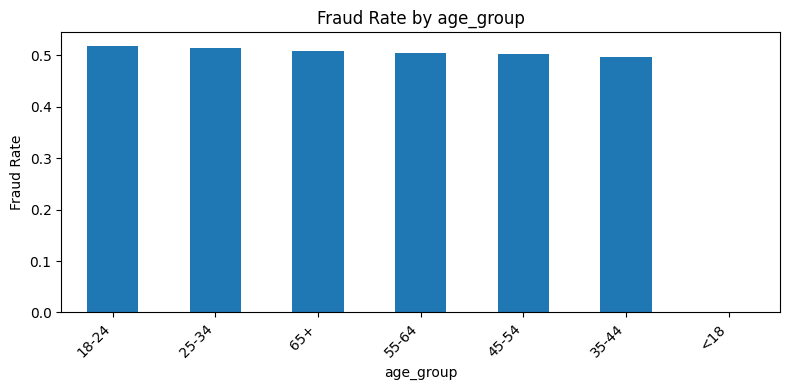

Saved figure to: C:\Users\akash\Spendsense-financial-intelligence\reports\figures\fraud_by_age_group_age_group.png


In [40]:
# Bin customer_age into age groups for clearer plots
if "customer_age" in df.columns:
    age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
    age_labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

    df["age_group"] = pd.cut(df["customer_age"], bins=age_bins, labels=age_labels, right=False)

    plot_fraud_rate_by_column(df, "age_group", filename_prefix="fraud_by_age_group")
else:
    print("customer_age column not available; skipping age analysis.")


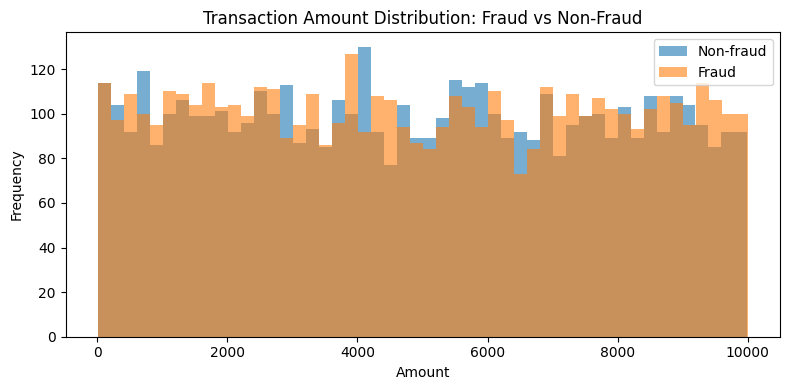

Saved figure to: C:\Users\akash\Spendsense-financial-intelligence\reports\figures\amount_distribution_fraud_vs_nonfraud.png


In [41]:
# Compare amount distribution for fraudulent vs non-fraudulent transactions
plt.figure(figsize=(8, 4))

# Non-fraud
df[df["is_fraudulent"] == 0]["amount"].plot(
    kind="hist",
    bins=50,
    alpha=0.6,
    label="Non-fraud"
)

# Fraud
df[df["is_fraudulent"] == 1]["amount"].plot(
    kind="hist",
    bins=50,
    alpha=0.6,
    label="Fraud"
)

plt.title("Transaction Amount Distribution: Fraud vs Non-Fraud")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

fig_path = FIGURES_DIR / "amount_distribution_fraud_vs_nonfraud.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print("Saved figure to:", fig_path)


In [42]:
fraud_rate_pct = df["is_fraudulent"].mean() * 100

summary = f"""
Key EDA Findings (high level):

- Overall fraud rate: {fraud_rate_pct:.2f}%
- See saved figures in: {FIGURES_DIR}

Use these plots and insights to:
- Update docs/eda_summary.md
- Add a short narrative in README.md about the dataset and main patterns.
"""

print(summary)



Key EDA Findings (high level):

- Overall fraud rate: 50.68%
- See saved figures in: C:\Users\akash\Spendsense-financial-intelligence\reports\figures

Use these plots and insights to:
- Update docs/eda_summary.md
- Add a short narrative in README.md about the dataset and main patterns.

